# TP 2:  

### import libraries 

In [2]:
import os
import powerlaw                     as pl      
import numpy                        as np
import matplotlib.pyplot            as plt
import pandas                       as pd
from  matplotlib.ticker             import PercentFormatter
from  scipy.stats                   import norm,expon,weibull_min,t,laplace
from  scipy.optimize                import curve_fit
from  statsmodels.graphics.tsaplots import plot_acf

### import data

In [3]:
folder_path = './Data/BNPP.PA'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and 'trades' in f]

df_trades = pd.DataFrame()
for f in file_names:
    gzip_file_path = folder_path+'/'+f
    df_trade = pd.read_csv(gzip_file_path, compression='gzip',index_col=None)
    del df_trade['Unnamed: 0']
    df_trade['ts'] = pd.to_datetime(df_trade['ts'])
    df_trades = pd.concat([df_trades,df_trade])

df_trades.tail(5)

,ts,price,volume
16628,2017-01-31 17:29:55.411,59.42,5.0
16629,2017-01-31 17:29:55.411,59.42,32.0
16630,2017-01-31 17:29:57.051,59.42,66.0
16631,2017-01-31 17:29:57.051,59.41,261.0
16632,2017-01-31 17:29:57.051,59.41,267.0


In [4]:
folder_path = './Data/BNPP.PA'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and 'quotes' in f]


list_dfs = []
for f in file_names:
    gzip_file_path = folder_path+'/'+f
    df = pd.read_csv(gzip_file_path, compression='gzip',index_col=None)
    del df['Unnamed: 0']
    df['ts'] = pd.to_datetime(df['ts'])
    df = df[['ts', 'bp1', 'bq1', 'ap1', 'aq1']]
    list_dfs.append(df)

df_quotes = pd.concat(list_dfs)

df_quotes.drop_duplicates(inplace=True)
df.drop_duplicates(inplace=True)

df_quotes.tail(5)

,ts,bp1,bq1,ap1,aq1
377041,2017-01-31 17:29:57.048,59.39,880,59.43,1148
377042,2017-01-31 17:29:57.048,59.39,880,59.42,261
377045,2017-01-31 17:29:57.048,59.39,880,59.42,309
377046,2017-01-31 17:29:57.048,59.39,680,59.42,309
377047,2017-01-31 17:29:57.048,59.39,419,59.42,309


In [5]:
df_quotes['spread'] = df_quotes['ap1']-df_quotes['bp1']
df_quotes['mid']    = 0.5*(df_quotes['bp1']+df_quotes['ap1'])
df_quotes['mid_weighted'] = (df_quotes['aq1']*df_quotes['bp1']+df_quotes['bq1']*df_quotes['ap1'])/(df_quotes['aq1']+df_quotes['bq1'])
df_quotes['imbalance'] = (df_quotes['bq1']-df_quotes['aq1'])/(df_quotes['aq1']+df_quotes['bq1'])

df['spread'] = df['ap1']-df['bp1']
df['mid']    = 0.5*(df['bp1']+df['ap1'])
df['mid_weighted'] = (df['aq1']*df['bp1']+df['bq1']*df['ap1'])/(df['aq1']+df['bq1'])
df['imbalance'] = (df['bq1']-df['aq1'])/(df['aq1']+df['bq1'])

### Question I

#### 1. Price and ticksize

1-1. Plot the evolution of the transaction price on the full sample

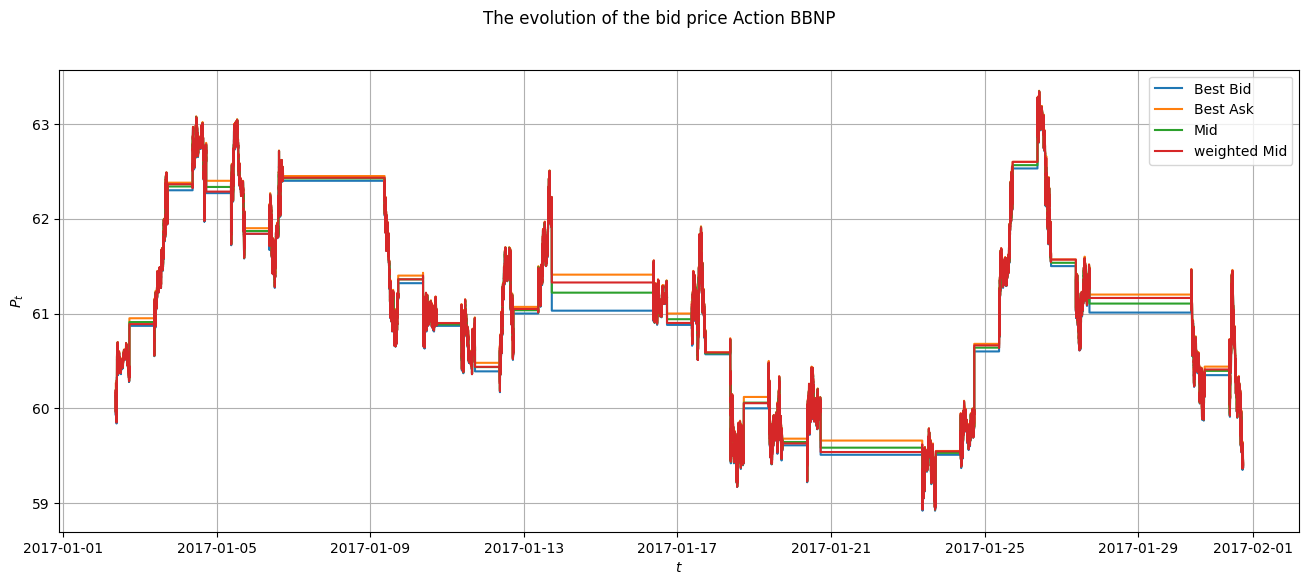

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of the bid price Action BBNP')

ax.step(df_quotes['ts'],df_quotes['bp1'],label=r'Best Bid')
ax.step(df_quotes['ts'],df_quotes['ap1'],label=r'Best Ask')
ax.step(df_quotes['ts'],df_quotes['mid'],label=r'Mid')
ax.step(df_quotes['ts'],df_quotes['mid_weighted'],label=r'weighted Mid')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$P_t$')
ax.grid()
ax.legend()

plt.show()

* Comments
    - We notice that the price is the same at the end of the weeek.
    - Over a month the price is between Low = 59 and High = 63
    - we notice big price jumps on the 3rd, 18th, 25th, and 26th on Juanary 2017
    - we notice that usually there are two jsmall jumps per day (*Open* and *Closing* moments) which can be explain by the price converging the optimal price 

1-2. Plot the evolution of the transaction price on a subset of a few minutes

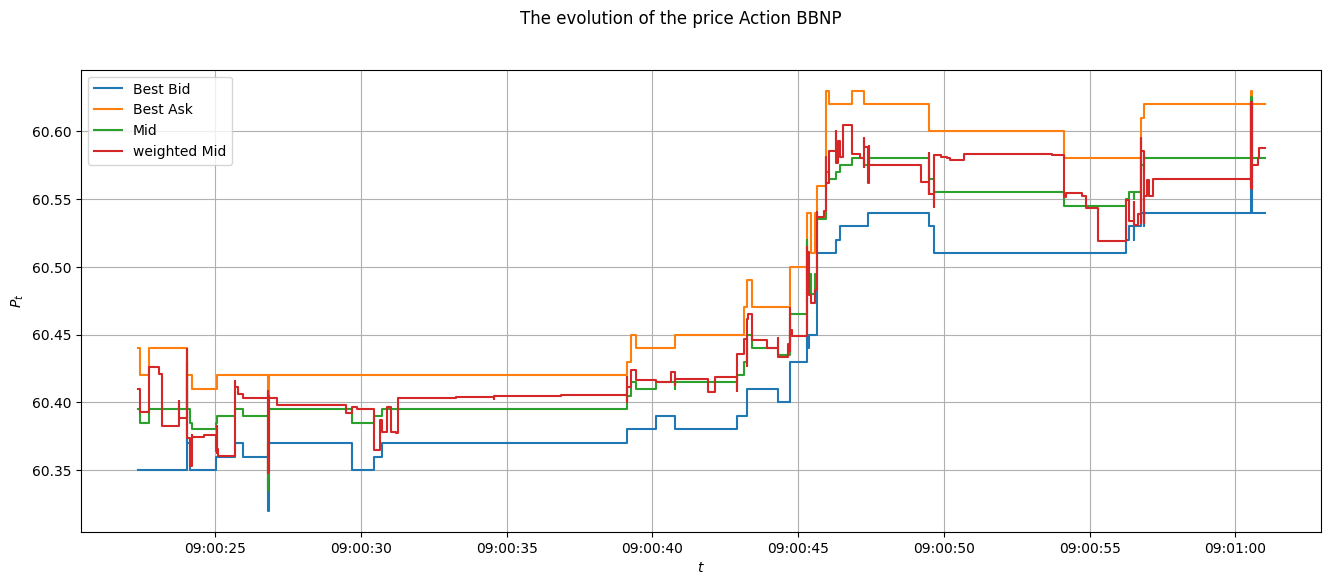

In [7]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of the price Action BBNP')

ax.step(df['ts'].iloc[:400],df['bp1'].iloc[:400],label=r'Best Bid')
ax.step(df['ts'].iloc[:400],df['ap1'].iloc[:400],label=r'Best Ask')
ax.step(df['ts'].iloc[:400],df['mid'].iloc[:400],label=r'Mid')
ax.step(df['ts'].iloc[:400],df['mid_weighted'].iloc[:400],label=r'weighted Mid')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$P_t$')
ax.grid()
ax.legend()

plt.show()

plt.show()

* Comments
    - in the plot above we plot the evolution of the price during 7 min on the 31th of January.
    - we notice the presence of small jumps and begger jumps. Usually the sammler jumps correspend to moving from a bid/ask order to an other 

#### 2. Spread distribution.

2.1 Plot a histogram of the spread distribution in event time (i.e. each observed value counts for
one observation).


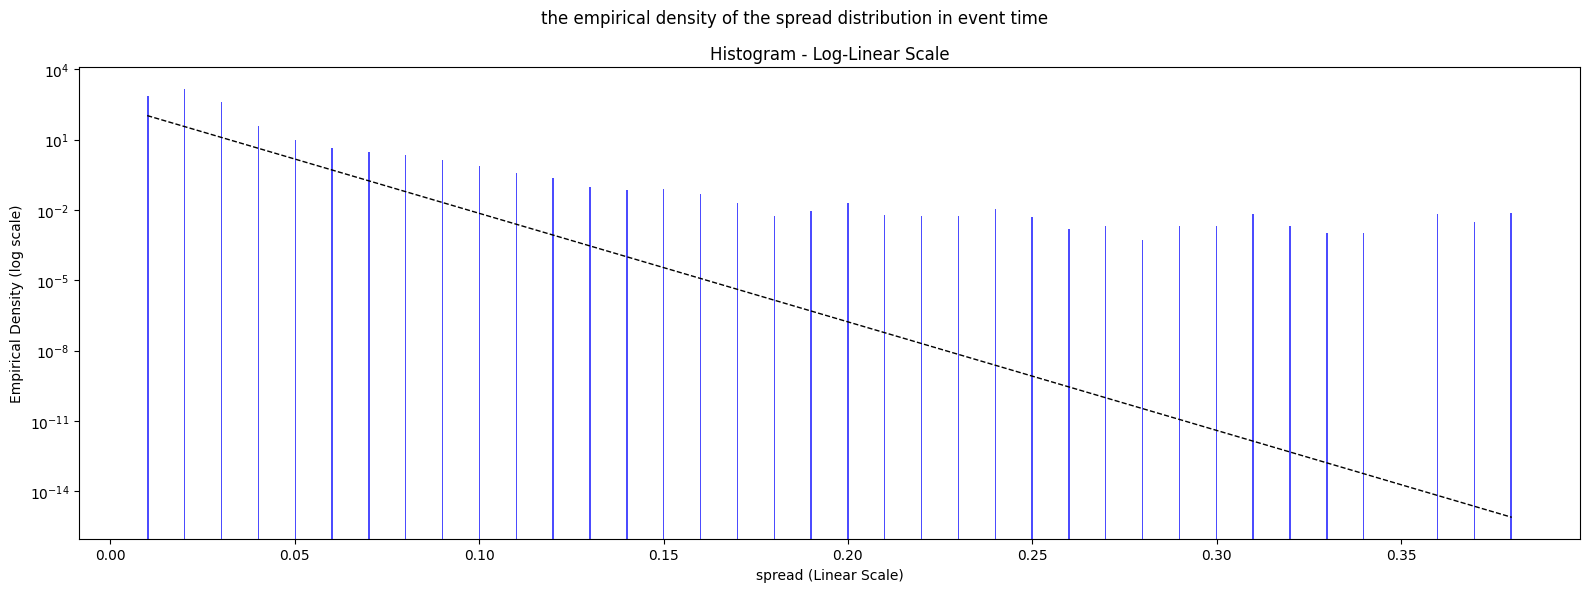

In [8]:
spread = df_quotes['spread'].values
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the spread distribution in event time')

params= expon.fit(spread)
xmin, xmax = np.min(spread), np.max(spread)
x = np.linspace(xmin, xmax, 100)
p = expon.pdf(x, *params)

ax.hist(spread, bins=1000, density=True, log=True, color='blue', alpha=0.7)
ax.plot(x, p, linewidth=1,color='black',label=' exponential fit',linestyle='--')
#ax.set_xscale('log')
ax.set_title('Histogram - Log-Linear Scale')
ax.set_xlabel('spread (Linear Scale)')
ax.set_ylabel('Empirical Density (log scale)')

plt.tight_layout()
plt.show()

2.2 Plot a histogram of the spread distribution in calendar time (i.e. each observed value is
weighted by the length of the time interval on which it is observed).

In [9]:
df_spread = df.copy()

df_spread['spread_changed'] = df_spread['spread'].diff().fillna(0).astype(bool)

df_spread['group'] = df_spread['spread_changed'].cumsum()
df_spread = df_spread.groupby('group').agg(
    start_time=('ts', 'first'),
    end_time=('ts', 'last'),
    spread=('spread', 'first'),
    duration=('ts', lambda x: (x.iloc[-1] - x.iloc[0]))
).reset_index(drop=True)
df_spread['duration'] =  (df_spread['duration'].astype('int64') / 10**6).astype('int64')

weighted_spread = (df_spread['spread']*df_spread['duration']).values
xmin, xmax = np.min(weighted_spread), np.max(weighted_spread)
x = np.linspace(xmin, xmax, 100)

# Fitting with exponential distribution
params_expon = expon.fit(weighted_spread)
pdf_expon    = expon.pdf(x, *params_expon)

# Fitting with Powerlaw distribution
fit   = pl.Fit(weighted_spread)
alpha = fit.power_law.alpha

# Fitting with Weibul distribution
params_weibull = weibull_min.fit(weighted_spread)
pdf_weibull    = weibull_min.pdf(x, *params_weibull)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
C:\Users\mohamed iyadh laouej\AppData\Roaming\Python\Python39\site-packages\powerlaw.py:692: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


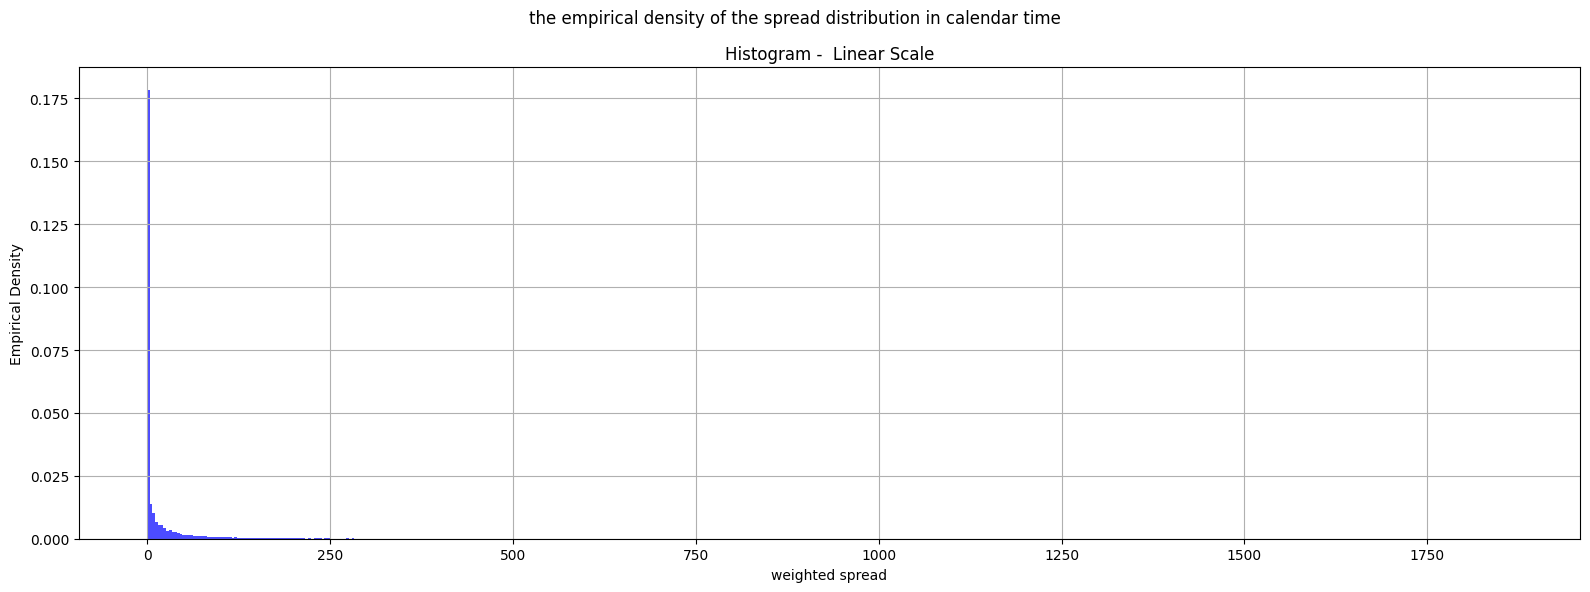

In [10]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the spread distribution in calendar time')

ax.hist(weighted_spread, bins=500, density=True, log=False, color='blue', alpha=0.7)
ax.set_title('Histogram -  Linear Scale')
ax.set_xlabel('weighted spread')
ax.set_ylabel('Empirical Density')
ax.grid()

plt.tight_layout()
plt.show()

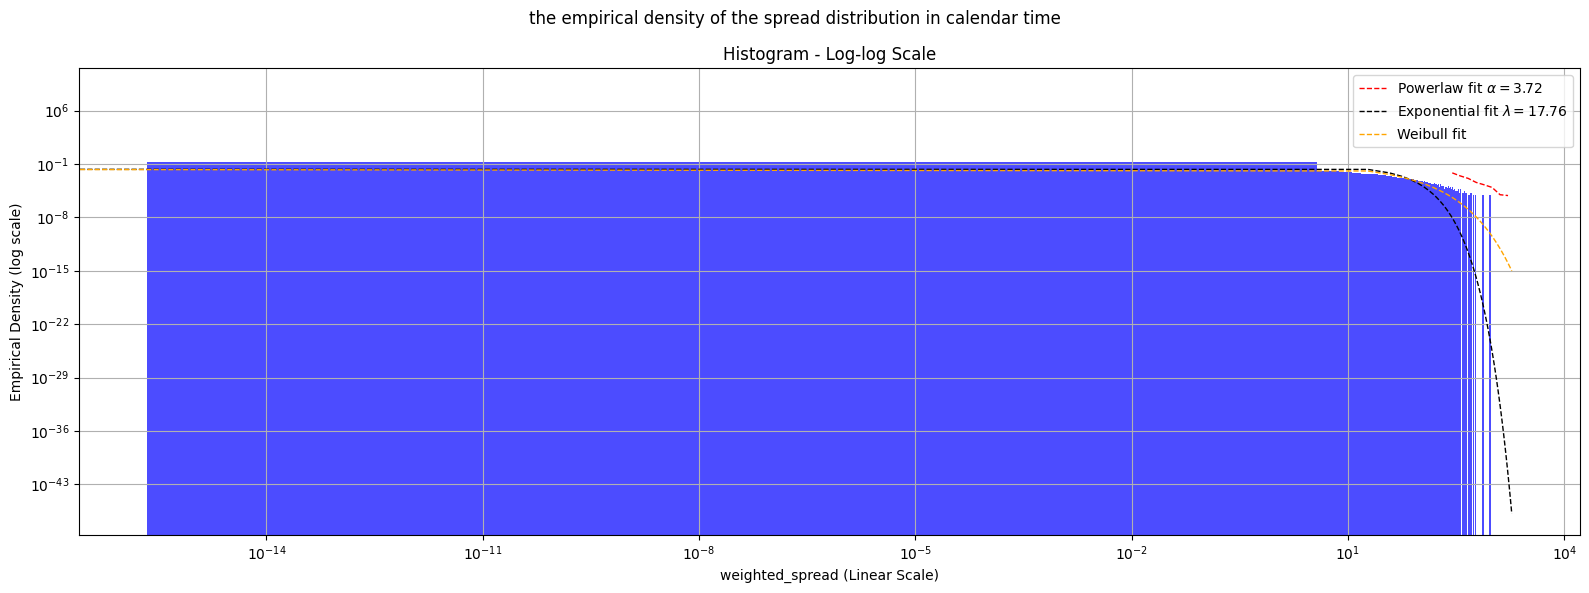

In [11]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the spread distribution in calendar time')

ax.hist(weighted_spread, bins=500, density=True, log=True, color='blue', alpha=0.7)
fit.plot_pdf(color='red', ax=ax,label=r'Powerlaw fit $\alpha =$'+f'{alpha:0.2f}',linestyle='--',linewidth=1)
ax.plot(x, pdf_expon  , linewidth=1, color='black' , label=r'Exponential fit $\lambda=$'+f'{params_expon[-1]:.2f}',linestyle='--')
ax.plot(x, pdf_weibull, linewidth=1, color='orange', label='Weibull fit',                                          linestyle='--')
#ax.set_xscale('log')
ax.set_title('Histogram - Log-log Scale')
ax.set_xlabel('weighted_spread (Linear Scale)')
ax.set_ylabel('Empirical Density (log scale)')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

**Comments**

- The weighted spread has a heavy tail distribution  

#### 3. Imbalance and mid-price movements.

3.1 Plot the imbalance distribution.

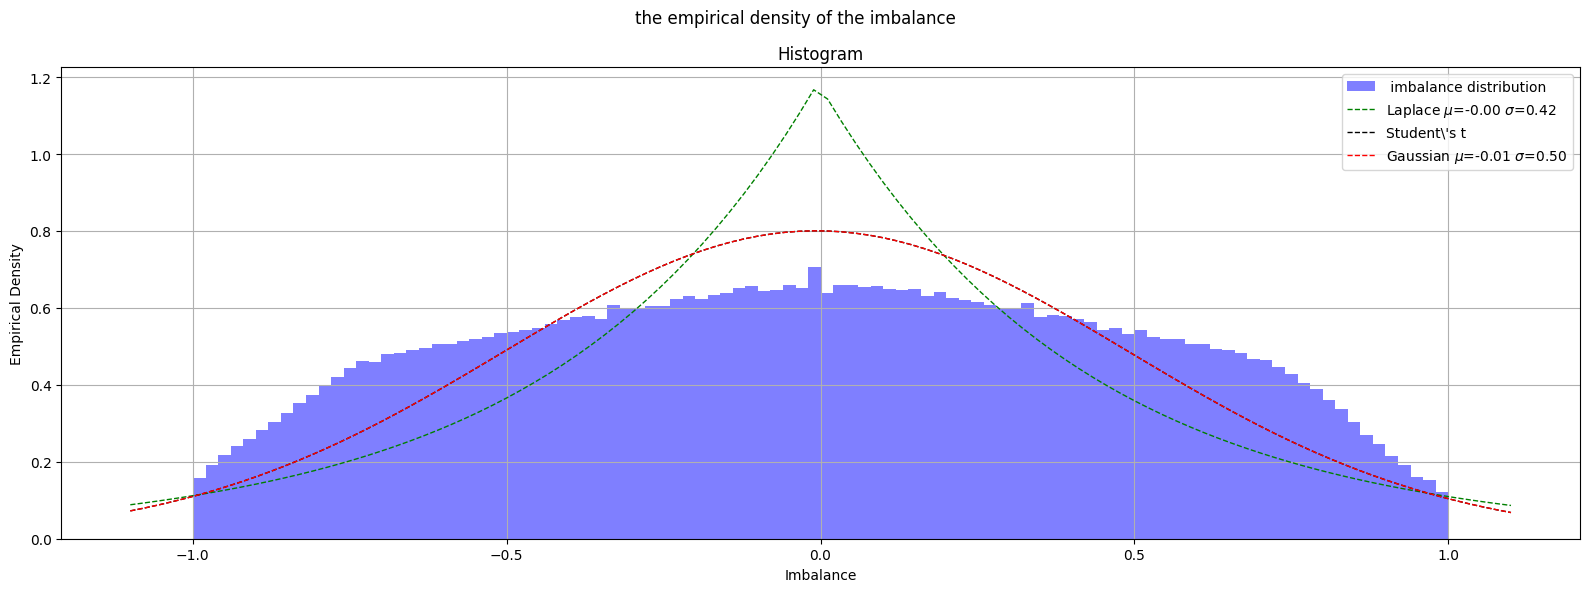

In [12]:
imbalance = df_quotes['imbalance'].values

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the empirical density of the imbalance')

ax.hist(imbalance, bins=100, density=True, log=False, color='blue', alpha=0.5,label=' imbalance distribution')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Fit Student's t-distribution
t_params = t.fit(imbalance)
pdf_t = t.pdf(x, *t_params)
# Fit Gaussian distribution
mu, sigma = norm.fit(imbalance)
pdf_norm = norm.pdf(x, mu, sigma)
# Fit Laplace distribution
loc, scale = laplace.fit(imbalance)
laplace_pdf = laplace.pdf(x, loc=loc, scale=scale)

ax.plot(x, laplace_pdf, 'g', linewidth=1,linestyle='--', label=r'Laplace $\mu$='+f'{loc:.2f}'+r' $\sigma$='+f'{scale:.2f}')
ax.plot(x, pdf_t      , 'k', linewidth=1,linestyle='--', label=r'Student\'s t')
ax.plot(x, pdf_norm   , 'r', linewidth=1,linestyle='--', label=r'Gaussian $\mu$='+f'{mu:.2f}'+r' $\sigma$='+f'{sigma:.2f}')
ax.set_title('Histogram')
ax.set_xlabel('Imbalance')
ax.set_ylabel('Empirical Density')
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

3.2 Compute the average non-zero mid-price movement as a function of the observed imbalance
before the price movement.


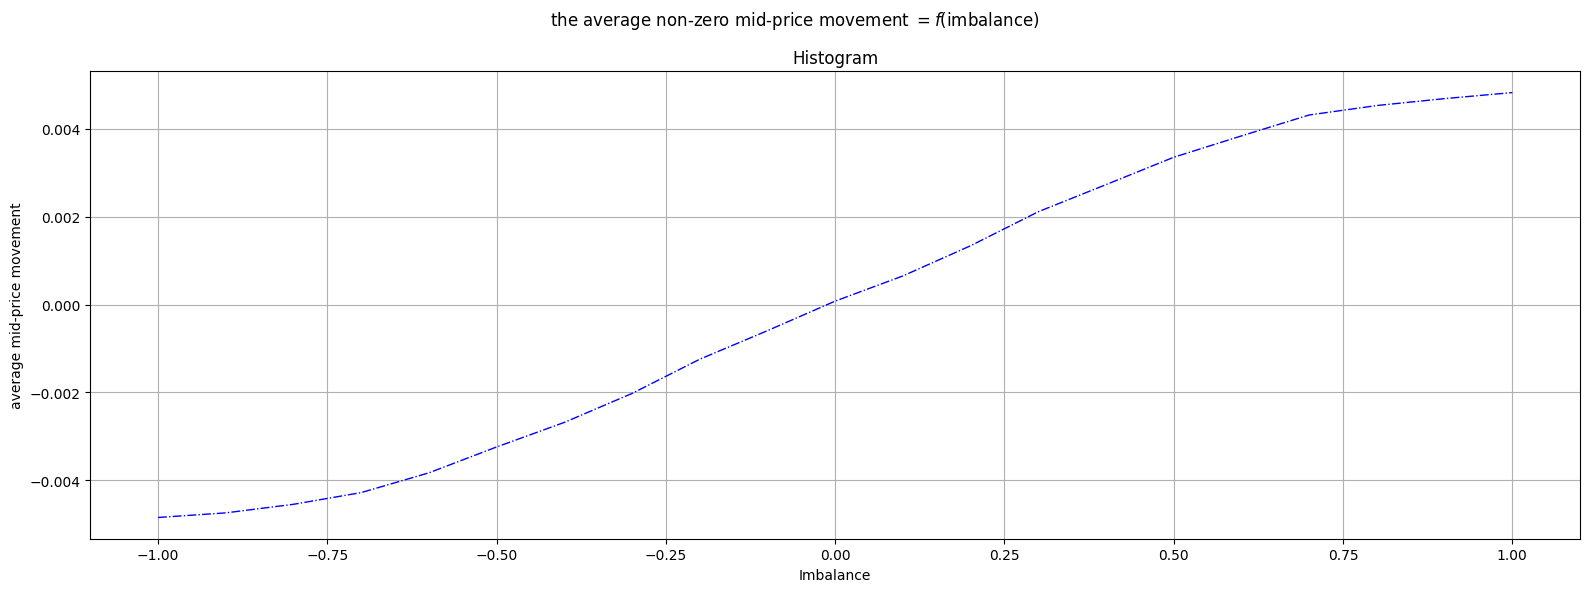

In [13]:
df_imbalance_mid = df_quotes.copy()
df_imbalance_mid['mid movements'] = (df_imbalance_mid['mid'].shift(-1) - df_imbalance_mid['mid'])
df_imbalance_mid.dropna(inplace=True)
df_imbalance_mid = df_imbalance_mid[~(df_imbalance_mid['mid movements']==0)]
df_imbalance_mid['imbalance'] = df_imbalance_mid['imbalance'].round(1) #Choose Granularity
df_imbalance_mid_grouped = df_imbalance_mid.groupby('imbalance').agg(mid=('mid movements', 'mean'))
df_imbalance_mid_grouped.reset_index(inplace=True)
df_imbalance_mid_grouped.sort_values(by=['imbalance'],ascending=True)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the average non-zero mid-price movement $=f($imbalance$)$')

ax.plot(df_imbalance_mid_grouped['imbalance'], df_imbalance_mid_grouped['mid'], 'blue', linewidth=1,linestyle='-.')#
ax.set_title('Histogram')
ax.set_xlabel('Imbalance')
ax.set_ylabel(r'average mid-price movement')
ax.grid()

plt.tight_layout()
plt.show()

**Comment**
- We notice that the average non-zero mid-price is increasing of the observed imbalance.  When the imbalance is negative the Ask volume is very high so we expect the price to go down (Bearish movement). When the imbalance is positive the bid volume is very high so we expect to go up (Bullish movement). 

3.4 Compute the average non-zero mid-price movement as a function of the observed imbalance
before the price movement, conditionnally on the spread.

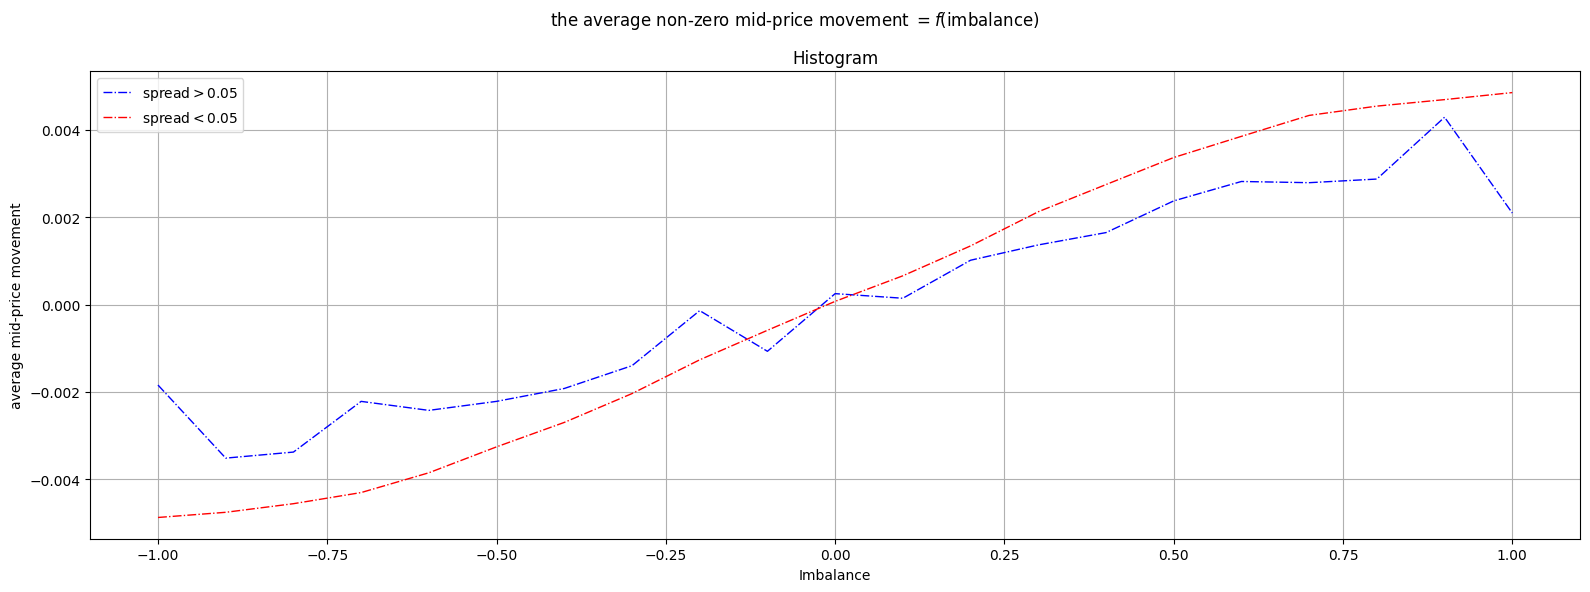

In [14]:
df_imbalance_mid = df_quotes.copy()
df_imbalance_mid['mid movements'] = (df_imbalance_mid['mid'].shift(-1) - df_imbalance_mid['mid'])
df_imbalance_mid.dropna(inplace=True)
df_imbalance_mid = df_imbalance_mid[~(df_imbalance_mid['mid movements']==0)]
df_imbalance_mid['imbalance'] = df_imbalance_mid['imbalance'].round(1)
df_imbalance_mid['spread'] = df_imbalance_mid['spread'].round(2)
spread_threshold = 0.05
df_imbalance_mid['spread map'] = np.where(df_imbalance_mid['spread']>spread_threshold,1,0) 
df_imbalance_mid['imbalance'] = df_imbalance_mid['imbalance'].round(1)
df_imbalance_mid_grouped = df_imbalance_mid.groupby(['imbalance','spread map']).agg(mid=('mid movements', 'mean'))
df_imbalance_mid_grouped.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the average non-zero mid-price movement $=f($imbalance$)$')

ax.plot(df_imbalance_mid_grouped[df_imbalance_mid_grouped['spread map']==1]['imbalance'], df_imbalance_mid_grouped[df_imbalance_mid_grouped['spread map']==1]['mid'], 'blue', linewidth=1,linestyle='-.',label=r'spread$>$'+f'{spread_threshold}')#
ax.plot(df_imbalance_mid_grouped[df_imbalance_mid_grouped['spread map']==0]['imbalance'], df_imbalance_mid_grouped[df_imbalance_mid_grouped['spread map']==0]['mid'], 'red', linewidth=1,linestyle='-.',label=r'spread$<$'+f'{spread_threshold}')#
ax.set_title('Histogram')
ax.set_xlabel('Imbalance')
ax.set_ylabel(r'average mid-price movement')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

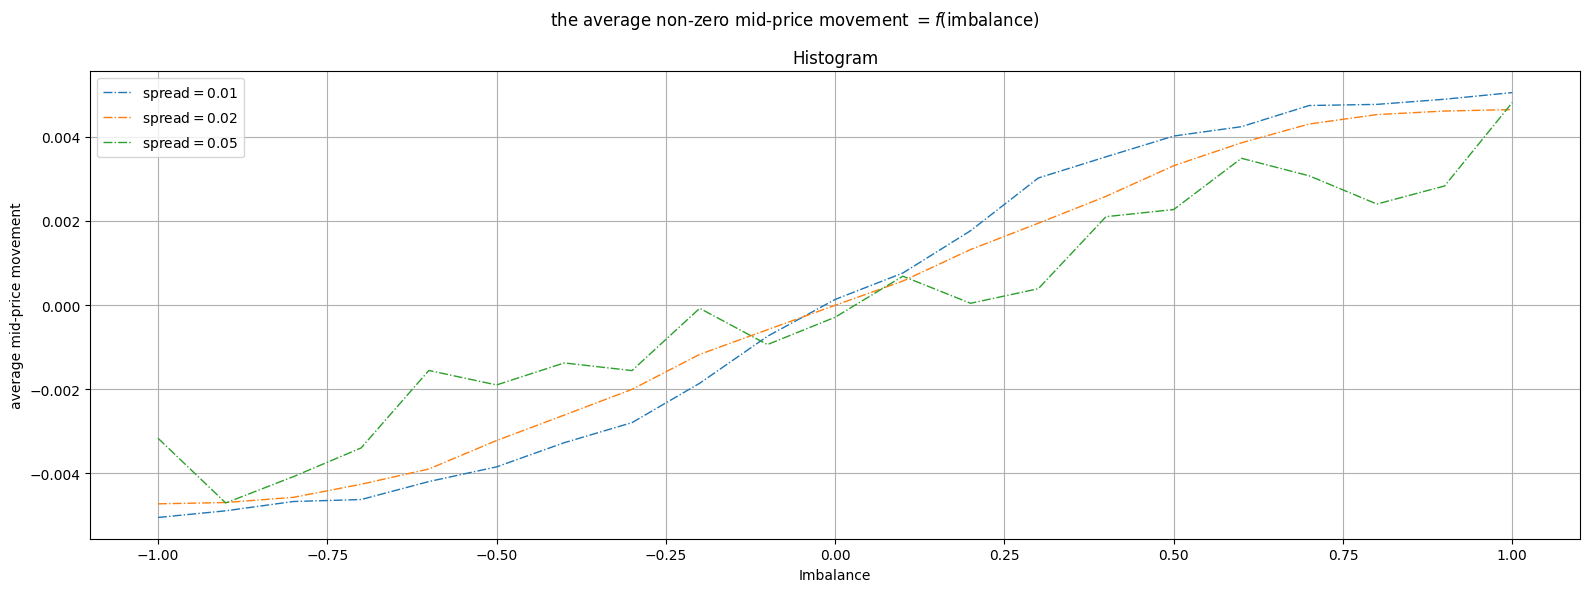

In [15]:
df_imbalance_mid = df_quotes.copy()
df_imbalance_mid['mid movements'] = (df_imbalance_mid['mid'].shift(-1) - df_imbalance_mid['mid'])
df_imbalance_mid.dropna(inplace=True)
df_imbalance_mid = df_imbalance_mid[~(df_imbalance_mid['mid movements']==0)]
df_imbalance_mid['imbalance'] = df_imbalance_mid['imbalance'].round(1)
df_imbalance_mid['spread'] = df_imbalance_mid['spread'].round(2)
df_imbalance_mid['imbalance'] = df_imbalance_mid['imbalance'].round(1)
df_imbalance_mid_grouped = df_imbalance_mid.groupby(['imbalance','spread']).agg(mid=('mid movements', 'mean'))
df_imbalance_mid_grouped.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the average non-zero mid-price movement $=f($imbalance$)$')
#for spread in df_imbalance_mid_grouped['spread'].unique():
for spread in [0.01,0.02,0.05]:
    ax.plot(df_imbalance_mid_grouped[df_imbalance_mid_grouped['spread']==spread]['imbalance'], df_imbalance_mid_grouped[df_imbalance_mid_grouped['spread']==spread]['mid'], linewidth=1,linestyle='-.',label=r'spread$=$'+f'{spread}')#

ax.set_title('Histogram')
ax.set_xlabel('Imbalance')
ax.set_ylabel(r'average mid-price movement')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

**Comment**
- We notice that when spread is High thes is a lack of liquadity we notice that the tendency becomes noisy. This is expected since the spread is measure of volatility of the Makert so the we expect a more eratic behaviour. 

### Question II

#### 4. Autocorrelation of trade signs and order book events

4.1 Sign the trades using a tick test and plot the autocorrelation of the trade signs.


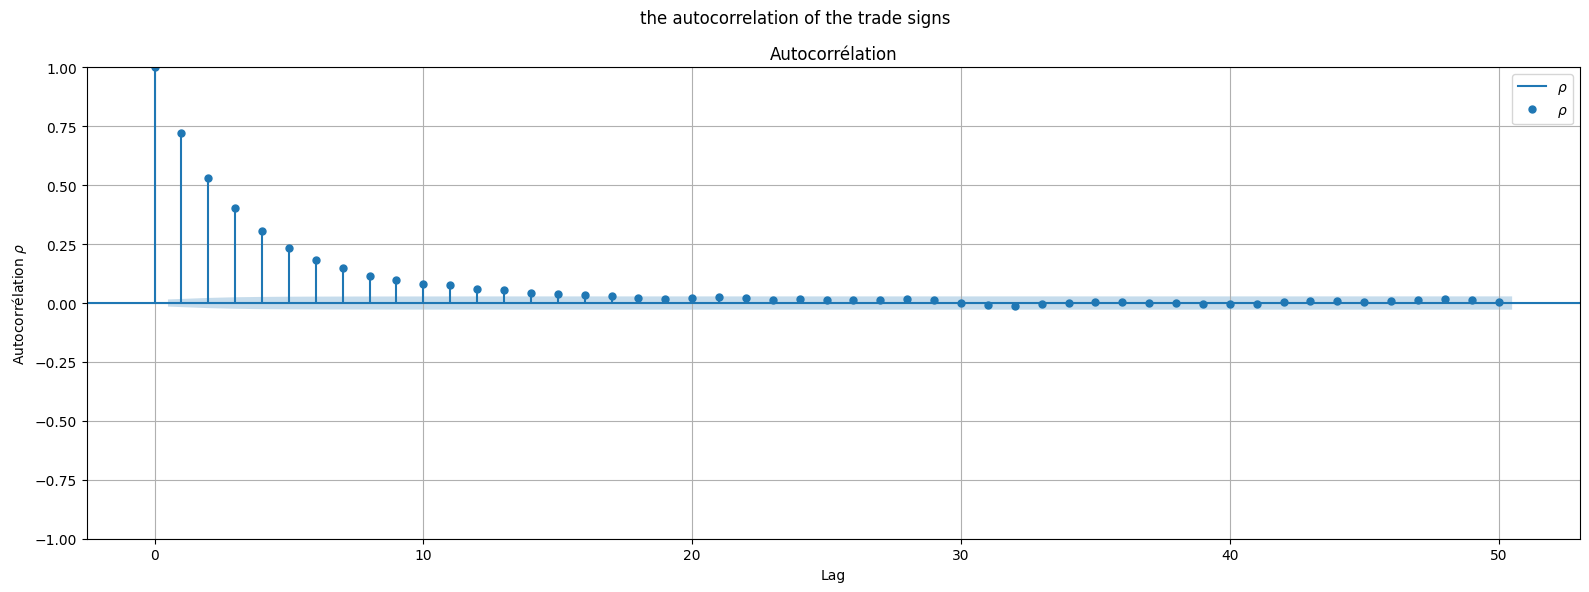

In [16]:
df_tick_test = df_trade.copy()
df_tick_test['tick test'] = 0

change_price = df_tick_test['price'].diff()
positive = change_price>0
negative = change_price<0
df_tick_test.loc[positive,'tick test'] = 1
df_tick_test.loc[negative,'tick test'] = -1
mask = (df_tick_test['tick test'] == 0)
df_tick_test.loc[mask, 'tick test'] = None
df_tick_test['tick test'] = df_tick_test['tick test'].ffill()
df_tick_test.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the autocorrelation of the trade signs')

plot_acf(df_tick_test['tick test'],ax=ax ,lags=50, alpha=0.05,label=r'$\rho$')
ax.set_title('Autocorrélation')
ax.set_xlabel('Lag')
ax.set_ylabel(r'Autocorrélation $\rho$')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

4.2 Sign the sides of the mid-price moves and plot the autocorrelation of this timeseries

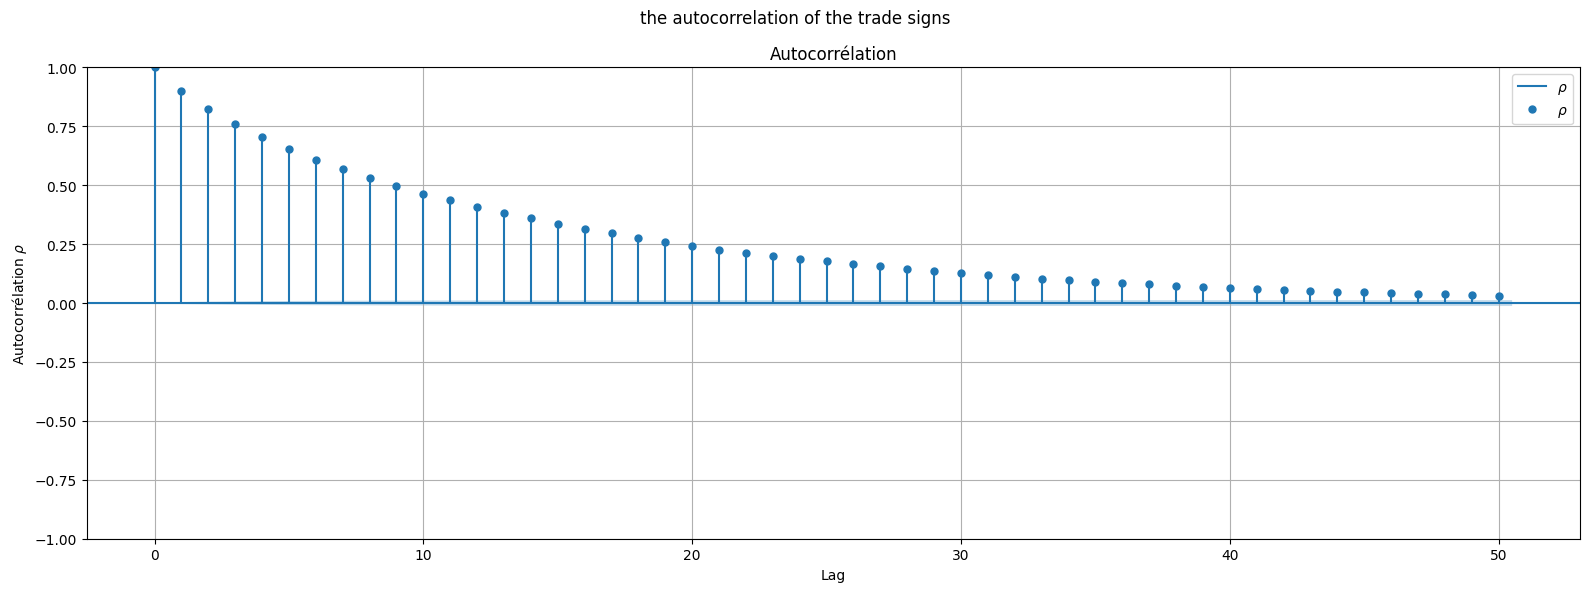

In [17]:
df_tick_test = df.copy()
df_tick_test['tick test'] = 0

change_price = df_tick_test['mid'].diff()
positive = change_price>0
negative = change_price<0
df_tick_test.loc[positive,'tick test'] = 1
df_tick_test.loc[negative,'tick test'] = -1
mask = (df_tick_test['tick test'] == 0)
df_tick_test.loc[mask, 'tick test'] = None
df_tick_test['tick test'] = df_tick_test['tick test'].ffill()
df_tick_test.dropna(inplace=True)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'the autocorrelation of the trade signs')

plot_acf(df_tick_test['tick test'],ax=ax ,lags=50, alpha=0.05,label=r'$\rho$')
ax.set_title('Autocorrélation')
ax.set_xlabel('Lag')
ax.set_ylabel(r'Autocorrélation $\rho$')
ax.grid()
ax.legend()

plt.tight_layout()
plt.show()

* Comments:

Time series of trade signs exhibit long-memory. This can be explained by the Mega orders which are excuted over a long period of time which create long meromy in the timeserie 

#### 5. Volatility signature plot.

5.1 Compute the volatility signature plot using the mid-price.

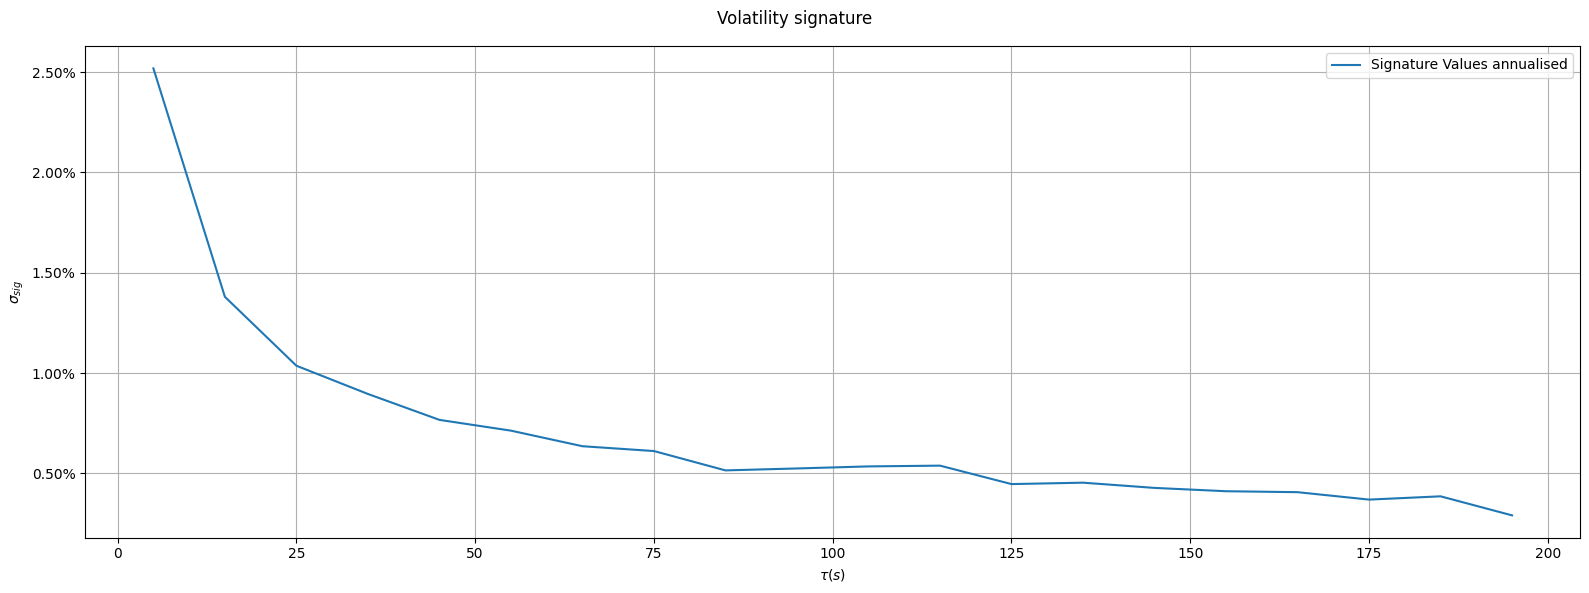

In [18]:
df_vol_signature = df[['ts','mid']].copy()                  
df_vol_signature.set_index('ts', inplace=True)

vol_signature_values = []
taux = np.arange(5,200,10)
Coef = 8*3600
for t in taux:
    index = str(int(t))+'s'
    vol_signature = np.log(df_vol_signature['mid']).resample(index).last().ffill()
    Value = (((vol_signature - vol_signature.shift(1)).dropna())**2).sum()
    Value = np.sqrt(Coef/t)*Value
    vol_signature_values.append(Value)

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'Volatility signature')

ax.plot(taux, vol_signature_values, label='Signature Values annualised')

ax.legend()
ax.grid()
ax.set_xlabel(r'$\tau(s)$')
ax.set_ylabel(r'$\sigma_{sig}$')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.tight_layout()
plt.show()

We ntoice the same shape as the plot of the Volatility signature of the price of the trades

#### 6. Average shape of the LOB.

6.1 Make a bar plot of the average shape of the LOB (one bar per level on each side).

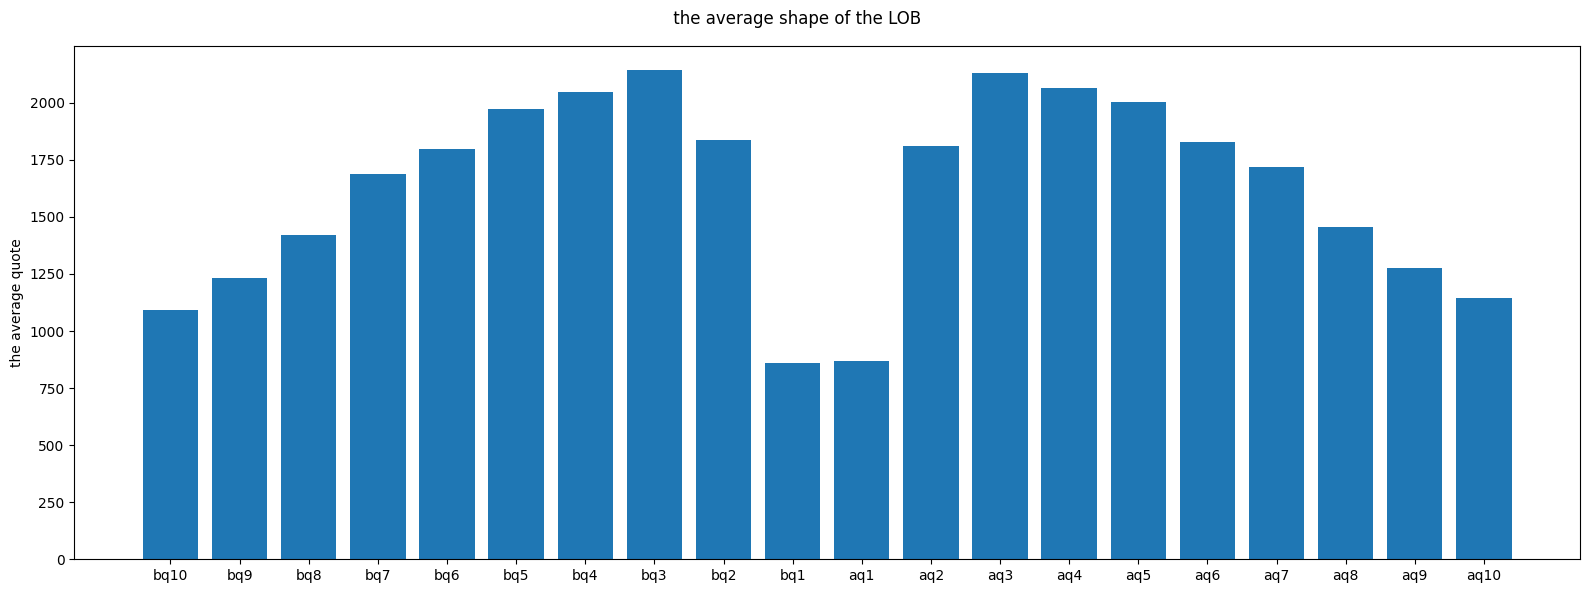

In [19]:
folder_path = 'Data/BNPP.PA'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and 'quotes' in f]
List_columns = ['bq10','bq9', 'bq8','bq7','bq6','bq5','bq4','bq3','bq2','bq1','aq1','aq2','aq3','aq4','aq5','aq6','aq7','aq8','aq9','aq10']

list_dfs = []
for f in file_names:
    gzip_file_path = folder_path+'/'+f
    df = pd.read_csv(gzip_file_path, compression='gzip',index_col=None)
    df = df[List_columns]
    df = pd.DataFrame(df.mean()).T
    list_dfs.append(df)

df_LOB = pd.concat(list_dfs,axis=0)
df_LOB = pd.DataFrame(df_LOB.mean())

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r' the average shape of the LOB')

ax.bar(df_LOB.index, df_LOB.iloc[:, 0])
ax.set_ylabel(r'the average quote')

plt.tight_layout()
plt.show()

* Comments

Average shape of the LOB exhibits a humped-shape with a maximum away from the best prices. We notice that the most of the liquidity is provided around the best quotes.